In [1]:
with open('data/prices_cryptocompare.txt', 'r') as file:
    ext_market_prices = [float(line.strip()) for line in file]
    # for the purpose of this test, each price will be treated as a second (price at line 1 is second 1, price at line 10 is second 10, etc...)

In [2]:
import random

'''
There's an 80% chance that a normal user performs an action (buy or sell).
Out of the 80%, there's a 60% probability that they buy and 40% probability that they sell.
'''
def user_action():
    # probability that the user performs an action (either buy or sell)
    buy_sell_prob = 0.8
    # probability that the user doesn't perform any action
    pass_prob = 1 - buy_sell_prob
    action = random.choices(['buy', 'sell', 'pass'], [buy_sell_prob, buy_sell_prob, pass_prob])[0]
    if action in ['buy', 'sell']:
        buy_prob = 0.6
        sell_prob = 0.4
        action = random.choices([action], [buy_prob if action == 'buy' else sell_prob])[0]
    return action

In [3]:
from amms.xrpl.amm.actions import Swap
from amms.xrpl.amm.env import User
from amms.uniswap.uniswap import Uniswap_amm

# block confirmation times (in seconds)
xrpl_block_conf = 3 # it's actually 4 but the index in python starts at 0
eth_block_conf = 11 # it's actually 12 but the index in python starts at 0
# transaction fees (in USDC token)
xrpl_fees = 0.0000075 # USDC (at 0.00002 XRP/tx)
eth_fees = 5 # USDC

xrpl_safe_profit_margin = xrpl_fees + 5
eth_safe_profit_margin = eth_fees + 5

xrpl_profits_total = []
uniswap_profits_total = []
xrpl_arbit_txs_total = []
uniswap_arbit_txs_total = []

iterations = 10
for iteration in range(iterations):
    '''
    At each iteration, we set the users and AMMs statuses to their initial one and re-run the simulation.
    Each iteration is independent of the previous one.
    The amounts of assets chosen when initiating the AMMs are done so that the initial spot price is the same 
    as the first price in the prices_cryptocompare.txt file and so that the AMMs don't "run out" of tokens.
    '''
    # bob = normal user on xrpl
    bob = User(user_name='bob', assets={'XRP':1000, 'ETH':1000000000, 'USDC':1360720000000000})
    # arbit = arbitrageur on xrpl
    arbit = User(user_name='arbit', assets={'XRP':1000, 'ETH':1000000, 'USDC':100000000000000})
    # xrpl AMM
    xrpl_amm = bob.createAMM(ammID=1, asset1='ETH', asset2='USDC', amount1=8300000, amount2=13607200000)
    # initiate both bob and arbit swap objects on xrpl in order to let them make swaps
    bob_swaps = Swap(bob, xrpl_amm)
    arbit_swaps = Swap(arbit, xrpl_amm)
    # uniswap AMM
    uniswap_amm = Uniswap_amm(fee_rate=0.005, asset_A_amount=8300000, asset_B_amount=13607200000, initial_LP_token_number=29200)

    xrpl_profits = [] # profits made by the arbitrageur on xrpl (in USDC)
    uniswap_profits = [] # profits made by the arbitrageur on uniswap (in USDC)
    xrpl_arbit_txs = 0 # number of transactions made by the arbitrageur on xrpl
    uniswap_arbit_txs = 0 # number of transactions made by the arbitrageur on uniswap
    current_xrpl_txs = [] 
    current_uniswap_txs = []
    for i in range(len(ext_market_prices)):
        # at every block confirmation (4s for xrpl and 12s for ethereum), we update the pool statuses of both AMMs (spot prices, amounts of assets, etc...)
        if i % xrpl_block_conf == 0:
            if len(current_xrpl_txs) > 0:
                for tx in current_xrpl_txs:
                    tx('USDC')
            current_xrpl_txs = []
            xrpl_sp = xrpl_amm.spot_price1('USDC', 'ETH')
        if i % eth_block_conf == 0:
            if len(current_uniswap_txs) > 0:
                for tx in current_uniswap_txs:
                    tx(sp=1)
            current_uniswap_txs = []
            uniswap_sp = uniswap_amm.check_SP_price('A')

        action = user_action()
        if action == 'buy':
            amount = random.uniform(0.1, 1) # user will buy between 0.1 and 1 ETH
            current_xrpl_txs += [lambda assetIn: bob_swaps.swap_given_amount_Out(assetIn=assetIn, assetOut='ETH', amountOut=amount)]
            current_uniswap_txs += [lambda sp: uniswap_amm.swap('A', amount, sp)]
        elif action == 'sell':
            amount = random.uniform(0.1, 1) # user will sell between 0.1 and 1 ETH
            current_xrpl_txs += [lambda assetOut: bob_swaps.swap_given_amount_Out(assetIn='ETH', assetOut=assetOut, amountOut=amount*xrpl_sp)]
            current_uniswap_txs += [lambda sp: uniswap_amm.swap('B', amount*uniswap_sp, sp)]

        # XRPL
        if xrpl_sp > ext_market_prices[i]+xrpl_safe_profit_margin:
            amount = xrpl_sp # amount to swap (equivalent to 1 ETH)
            current_xrpl_txs += [lambda assetOut: arbit_swaps.swap_given_amount_Out(assetIn='ETH', assetOut=assetOut, amountOut=amount)]
            xrpl_profits += [(xrpl_sp - ext_market_prices[i]) - xrpl_fees]
            xrpl_arbit_txs += 1
        # XRPL    
        if xrpl_sp+xrpl_safe_profit_margin < ext_market_prices[i]:
            amount = 1 # amount to swap
            current_xrpl_txs += [lambda assetIn: arbit_swaps.swap_given_amount_Out(assetIn=assetIn, assetOut='ETH', amountOut=amount)]
            xrpl_profits += [(ext_market_prices[i] - xrpl_sp) - xrpl_fees]
            xrpl_arbit_txs += 1

        # UNISWAP
        if uniswap_sp > ext_market_prices[i]+eth_safe_profit_margin:
            amount = uniswap_sp # amount to swap (equivalent to 1 ETH)
            current_uniswap_txs += [lambda sp: uniswap_amm.swap('B', amount, sp)]
            uniswap_profits += [(uniswap_sp - ext_market_prices[i]) - eth_fees]
            uniswap_arbit_txs += 1
        # UNISWAP
        if uniswap_sp+eth_safe_profit_margin < ext_market_prices[i]:
            amount = 1 # amount to swap
            current_uniswap_txs += [lambda sp: uniswap_amm.swap('A', amount, sp)]
            uniswap_profits += [(ext_market_prices[i] - uniswap_sp) - eth_fees]
            uniswap_arbit_txs += 1

    xrpl_profits_total += [xrpl_profits]
    uniswap_profits_total += [uniswap_profits]
    xrpl_arbit_txs_total += [xrpl_arbit_txs]
    uniswap_arbit_txs_total += [uniswap_arbit_txs]

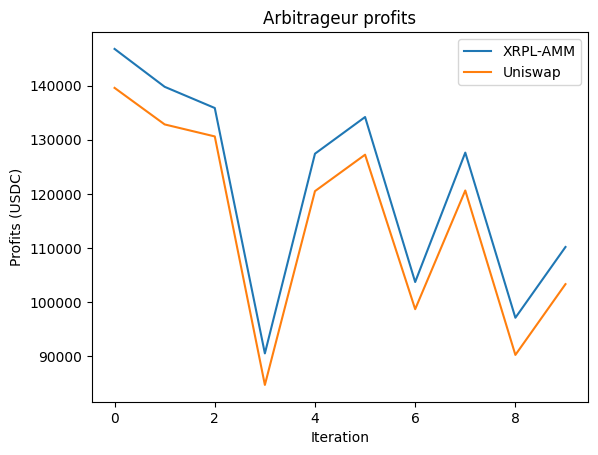

In [4]:
import matplotlib.pyplot as plt

xrpl_profits_sum = [sum(xrpl_profits_total[i]) for i in range(iterations)]
uniswap_profits_sum = [sum(uniswap_profits_total[i]) for i in range(iterations)]

x_axis = [i for i in range(iterations)]

plt.plot(x_axis, xrpl_profits_sum, label='XRPL-AMM')
plt.plot(x_axis, uniswap_profits_sum, label='Uniswap')

plt.xlabel('Iteration')
plt.ylabel('Profits (USDC)')
plt.title('Arbitrageur profits')
plt.legend()

plt.show()

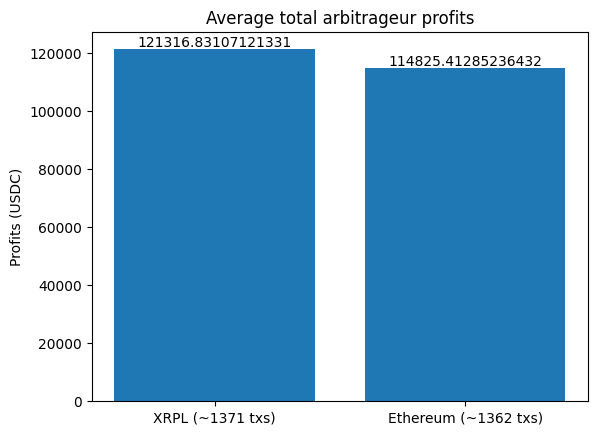

In [5]:
import numpy as np

avg_xrpl_profits = np.average(xrpl_profits_sum)
avg_eth_profits = np.average(uniswap_profits_sum)

avg_xrpl_txs = round(np.average(xrpl_arbit_txs_total))
avg_eth_txs = round(np.average(uniswap_arbit_txs_total))

x = ['XRPL (~'+f'{avg_xrpl_txs} txs)', 'Ethereum (~'+f'{avg_eth_txs} txs)']
y = [avg_xrpl_profits, avg_eth_profits]

plt.bar(x, y)
plt.text(x[0], y[0], avg_xrpl_profits, ha='center', va='bottom')
plt.text(x[1], y[1], avg_eth_profits, ha='center', va='bottom')
plt.ylabel('Profits (USDC)')
plt.title('Average total arbitrageur profits')

plt.show()

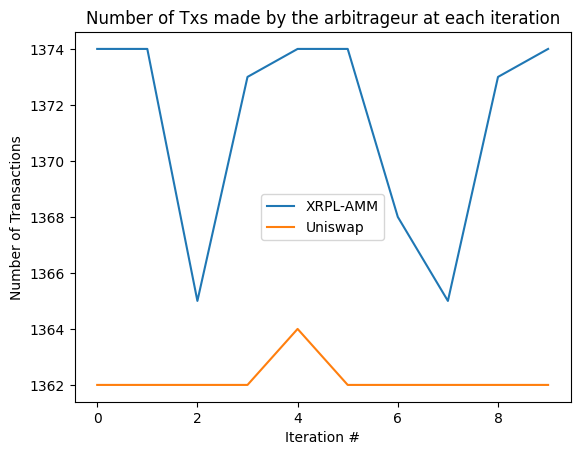

In [6]:
x_axis = [i for i in range(iterations)]

plt.plot(x_axis, xrpl_arbit_txs_total, label='XRPL-AMM')
plt.plot(x_axis, uniswap_arbit_txs_total, label='Uniswap')

plt.xlabel('Iteration #')
plt.ylabel('Number of Transactions')
plt.title('Number of Txs made by the arbitrageur at each iteration')
plt.legend()

plt.show()

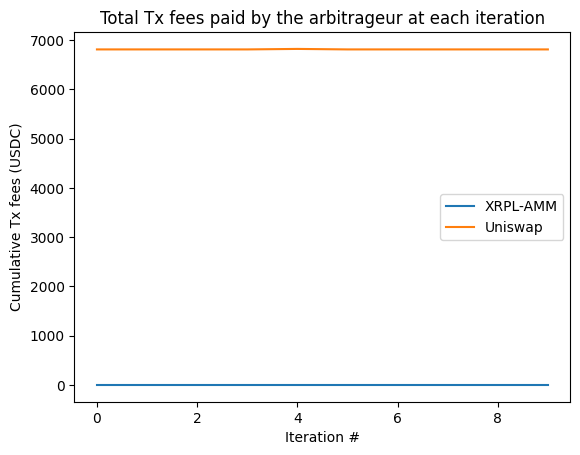

In [7]:
xrpl_fees_total = [i*xrpl_fees for i in xrpl_arbit_txs_total]
uniswap_fees_total = [i*eth_fees for i in uniswap_arbit_txs_total]

x_axis = [i for i in range(iterations)]

plt.plot(x_axis, xrpl_fees_total, label='XRPL-AMM')
plt.plot(x_axis, uniswap_fees_total, label='Uniswap')

plt.xlabel('Iteration #')
plt.ylabel('Cumulative Tx fees (USDC)')
plt.title('Total Tx fees paid by the arbitrageur at each iteration')
plt.legend()

plt.show()

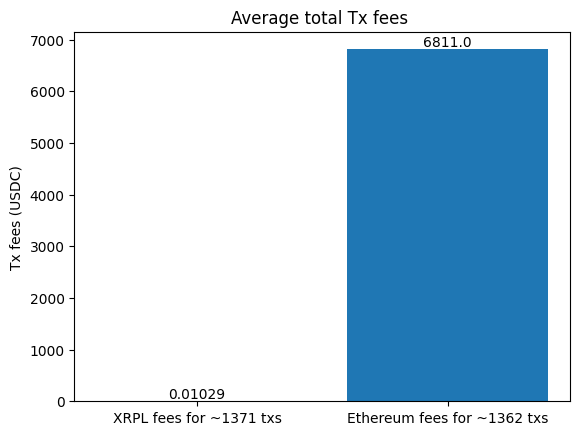

In [8]:
avg_xrpl_fees = np.average(xrpl_fees_total)
avg_eth_fees = np.average(uniswap_fees_total)

avg_xrpl_txs = round(np.average(xrpl_arbit_txs_total))
avg_eth_txs = round(np.average(uniswap_arbit_txs_total))

x = ['XRPL fees for ~'+f'{avg_xrpl_txs} txs', 'Ethereum fees for ~'+f'{avg_eth_txs} txs']
y = [avg_xrpl_fees, avg_eth_fees]

plt.bar(x, y)
plt.text(x[0], y[0], np.round(avg_xrpl_fees, 5), ha='center', va='bottom')
plt.text(x[1], y[1], np.round(avg_eth_fees, 5), ha='center', va='bottom')
plt.ylabel('Tx fees (USDC)')
plt.title('Average total Tx fees ')

plt.show()